## Hackaton - Anna Barcikowska

I decided to use python since i am more familiar with it. I start with loading the data and cleaning it.

## 0. Setup

I import all necessary libraries, set display options, and load the dataset files for:
- Bondora.csv - modelling dataset
- Description.xlsx - feature dictionary/variable descriptions




I start with importing all libraries

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, balanced_accuracy_score)
import matplotlib.pyplot as plt

 I load the datasets, check the shape, target distribution count and default rate for class balance. Then i review the data and try to familiarize myself with it :)

In [52]:
data_path = Path("Bondora.csv")
desc_path = Path("Description.xlsx")

df = pd.read_csv(data_path)
desc = pd.read_excel(desc_path)

print("Dataset shape:", df.shape)
print("Target distribution:\n", df["default"].value_counts())
print("Target default rate:", df["default"].mean().round(4))

df.head()

Dataset shape: (49207, 182)
Target distribution:
 default
0    30781
1    18426
Name: count, dtype: int64
Target default rate: 0.3745


,default,return,NPRP,NPRA,FVCI,new,Age,Gender,Interest,MonthlyPayment,DebtToIncome,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,time,time2,time3,Hour.0,Hour.1,Hour.2,Hour.3,Hour.4,Hour.5,Hour.6,Hour.7,Hour.8,Hour.9,Hour.10,Hour.11,Hour.12,Hour.13,Hour.14,Hour.15,Hour.16,Hour.17,Hour.18,Hour.19,Hour.20,Hour.21,Hour.22,weekday.1,weekday.2,weekday.3,weekday.4,weekday.5,weekday.6,ver.2,ver.3,ver.4,lang.1,lang.2,lang.3,lang.4,lang.6,log.amount,duration.06,duration.09,duration.12,duration.18,duration.24,duration.36,duration.48,duration.60,use.0,use.1,use.2,use.3,use.4,use.5,use.6,use.7,use.8,use.m,educ.2,educ.3,educ.4,educ.5,educ.6,marital.1,marital.2,marital.3,marital.4,marital.5,depen.0,depen.1,depen.2,depen.3,depen.4,employ.2,employ.3,employ.4,employ.5,employ.6,em.dur.5p,em.dur.other,em.dur.ret,em.dur.trial,em.dur.1y,em.dur.2y,em.dur.3y,em.dur.4y,em.dur.5y,exper.02y,exper.05y,exper.10y,exper.15y,exper.25y,exper.25p,Other,Mining,Processing,Energy,Utilities,Construction,Retail.wholesale,Transport.warehousing,Hospitality.catering,Info.telecom,Finance.insurance,Real.estate,Research,Administrative,Civil.service.military,Education,Healthcare.social.help,Art.entertainment,Agriculture.for.fish,homeless,owner,livingw.parents,tenant.pfp,council.house,joint.tenant,joint.ownership,mortgage,encumbrance,inc.princ.empl.no,inc.princ.empl.l,inc.pension.no,inc.pension.l,inc.fam.all.no,inc.fam.all.l,inc.soc.wel.no,inc.soc.wel.l,inc.leave.no,inc.leave.l,inc.child.no,inc.child.l,inc.other.no,inc.other.l,inc.total,no.liab.00,no.liab.01,no.liab.02,no.liab.03,no.liab.04,no.liab.05,no.liab.10,liab.l,no.refin.00,no.refin.01,no.refin.02,no.refin.03,no.refin.04,inc.support,FreeCash.d,FreeCash.l,no.previous.loan.00,no.previous.loan.01,no.previous.loan.02,no.previous.loan.03,no.previous.loan.04,no.previous.loan.05,no.previous.loan.06,no.previous.loan.07,previous.loan.l,no.previous.repay.00,no.previous.repay.01,previous.repay.l,A,AA,B,C
0,1,0.074888,49.694000,1490.82,1490.82,1,29,0,28.0,NaN,43.05,0,0.0,1.356,1.838736,2.493326,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,8.006368,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6.265301,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.000000,6.265301,0,0,0,1,0,0,0,4.852030,1,0,0,0,0,0.0,1,5.616444,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0,0,0,1
1,1,0.066162,75.237000,2257.11,2257.11,1,28,1,28.0,0.0,35.03,0,0.0,1.385,1.918225,2.656742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,8.006368,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.311735,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,0,3.663562,6.378426,0,0,0,0,0,0,1,6.066108,0,0,0,0,0,0.0,1,5.638355,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0,0,0,1
2,1,0.091230,36.766333,1102.99,1102.99,1,41,1,28.0,NaN,47.83,0,0.0,1.389,1.929321,2.679827,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,8.006368,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6.398595,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.000000,6.398595,0,0,0,1,0,0,0,5.147494,1,0,0,0,0,0.0,1,5.723291,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0,0,1,0
3,1,0.176189,28.499500,569.99,569.99,1,32,1,28.0,NaN,32.12,0,0.0,1.398,1.954404,2.732257,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,7.600902,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.363028,1,0.0,1,0.0,1,0.0,1,0.0,1,0.0,1,0.000000,6.363028,0,0,0,0,0,0,1,5.843544,0,0,1,0,0,0.0,1,5.590987,1,0,0,0,0,0,0,0,0.0,1,0,0.0,0,0,0,1
4,1,0.048933,34.016500,680.33,680.33,1,32,0,28.0,0.0,50.83,0,0.0,1.408,1.982464,2.7913

 We have 49,207 loans with 182 columns. The target is moderately imbalanced: 30,781 non-default and 18,426 default, so class weights/threshold tuning will make sense here. I also see plenty of rows for train/test splits and model training.

------

## 1. Data Analysis (EDA) 


In [53]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49207 entries, 0 to 49206
Columns: 182 entries, default to C
dtypes: float64(30), int64(152)
memory usage: 68.3 MB


None

I've got 49,207 rows and 182 columns, all numeric.

In [54]:
missing_rate = df.isna().mean().sort_values(ascending=False)
print("Top missing rates:")
display(missing_rate.head(20))

Top missing rates:


MonthlyPayment            0.041071
NPRP                      0.014469
NPRA                      0.014469
FVCI                      0.014469
return                    0.014469
employ.4                  0.000406
employ.2                  0.000406
employ.3                  0.000406
employ.6                  0.000406
employ.5                  0.000406
homeless                  0.000000
Research                  0.000000
Real.estate               0.000000
Administrative            0.000000
Civil.service.military    0.000000
Education                 0.000000
Healthcare.social.help    0.000000
Art.entertainment         0.000000
Agriculture.for.fish      0.000000
joint.tenant              0.000000
dtype: float64

These are the columns that contain any missing values. Only five have meaningful gaps: MonthlyPayment ( around 4.1%) and NPRP/NPRA/FVCI/return ( around 1.4% each).

In [55]:
key_cols = [c for c in ["Age","Interest","MonthlyPayment","DebtToIncome","NoOfPreviousLoansBeforeLoan","AmountOfPreviousLoansBeforeLoan","new"] if c in df.columns]
display(df[key_cols + ["default"]].describe(include="all").T)

,count,mean,std,min,25%,50%,75%,max
Age,49207.0,40.325381,11.848158,18.0,31.000000,39.000000,49.000000,75.000000
Interest,49207.0,18.546580,5.660209,6.0,14.320000,18.230000,21.870000,43.860000
MonthlyPayment,47186.0,4.023981,1.044672,0.0,3.152309,4.101155,4.771426,7.554607
DebtToIncome,49207.0,6.932058,15.189589,0.0,0.000000,0.000000,0.000000,75.250000
NoOfPreviousLoansBeforeLoan,49207.0,2.251509,2.824413,0.0,0.000000,1.000000,3.000000,26.000000
AmountOfPreviousLoansBeforeLoan,49207.0,4483.775895,5677.272773,0.0,0.000000,2335.000000,7227.000000,74740.000000
new,49207.0,0.398642,0.489624,0.0,0.000000,0.000000,1.000000,1.000000
default,49207.0,0.374459,0.483988,0.0,0.000000,0.000000,1.000000,1.000000


 This table shows that the variables have realistic ranges, it has many skewed features and shows some missing values in MonthlyPayment that i'll have to take care of.

Before building a model, I wanted to see how default risk changes across different groups of borrowers. I therefore after consulting the best options with Gemini decided to compare default rates for new vs. existing customers and across quartiles of key variables such as Age and MonthlyPayment.This allows me to detect non-linear patterns and risk segments in an interpretable way, without fitting a model yet.


new_vs_old


new
0    0.404515
1    0.329119
Name: default, dtype: float64


age_quartiles


Age
Q1    0.355471
Q2    0.337669
Q3    0.362003
Q4    0.442692
Name: default_rate, dtype: float64


monthlypayment_quartiles


MonthlyPayment
Q1    0.468170
Q2    0.352408
Q3    0.319346
Q4    0.402051
Name: default_rate, dtype: float64

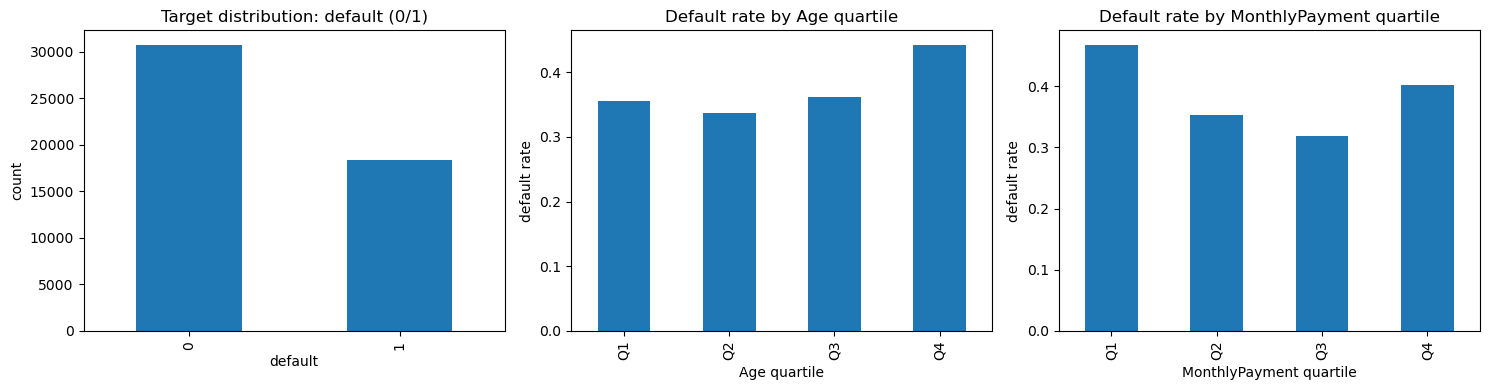

In [75]:
def default_rate_by_quantiles(frame, col, q=4):
    s = frame[col]
    bins = pd.qcut(s.rank(method="first"), q, labels=[f"Q{i+1}" for i in range(q)])
    out = frame.groupby(bins, observed=True)["default"].mean().rename("default_rate")
    return out

patterns = {}
if "new" in df.columns:
    patterns["new_vs_old"] = df.groupby("new")["default"].mean()

if "Age" in df.columns:
    patterns["age_quartiles"] = default_rate_by_quantiles(df, "Age", q=4)

if "MonthlyPayment" in df.columns:
    patterns["monthlypayment_quartiles"] = default_rate_by_quantiles(df.dropna(subset=["MonthlyPayment"]), "MonthlyPayment", q=4)

for k,v in patterns.items():
    print(f"\n{k}")
    display(v)

fig, axes = plt.subplots(1, 3, figsize=(15,4))

df["default"].value_counts().sort_index().plot(kind="bar", ax=axes[0])
axes[0].set_title("Target distribution: default (0/1)")
axes[0].set_xlabel("default")
axes[0].set_ylabel("count")

if "Age" in df.columns:
    dr_age = default_rate_by_quantiles(df, "Age", q=4)
    dr_age.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Default rate by Age quartile")
    axes[1].set_xlabel("Age quartile")
    axes[1].set_ylabel("default rate")

if "MonthlyPayment" in df.columns:
    dr_mp = default_rate_by_quantiles(df.dropna(subset=["MonthlyPayment"]), "MonthlyPayment", q=4)
    dr_mp.plot(kind="bar", ax=axes[2])
    axes[2].set_title("Default rate by MonthlyPayment quartile")
    axes[2].set_xlabel("MonthlyPayment quartile")
    axes[2].set_ylabel("default rate")

plt.tight_layout()
plt.show()


### What does it mean for me?

Based on the tables and graphs that I generated i came across three patterns
- Pattern 1 (new vs. existing): New borrowers have a lower default rate (about 33%) than existing borrowers (about 41%). This suggests that first-time borrowers may be screened more carefully or are generally less risky than repeat borrowers.

- Pattern 2 (Age): Default rates increase with age. The oldest age group has the highest default rate (around 44%), while younger and middle-age groups have lower rates (around 34–36%). This means older borrowers in this dataset are slightly more likely to default.
- Pattern 3 (MonthlyPayment): very low payments and very high payments have higher default; mid-range is lower. In detail, default risk varies by monthly payment size. Loans with very low monthly payments show the highest default rate (about 47%), while medium payment loans have lower default rates. Default risk increases again for the highest payment group. This suggests that both very small and very large payment amounts are linked to higher risk.


------

## 2. Data Transformation (and justification)

I check whether transformations are needed. 


Firstly, return column reflects post-loan performance. Using it would leak outcome information and inflate metrics. Dropping it keeps the model realistic for decision time.

In [57]:
y = df["default"].astype(int)
leakage_cols = [c for c in ["return"] if c in df.columns]
X = df.drop(columns=["default"] + leakage_cols)

print("Using X shape:", X.shape)
print("Leakage columns dropped:", leakage_cols)

Using X shape: (49207, 180)
Leakage columns dropped: ['return']


Then i check for empty columns

In [58]:
stds = df.std(numeric_only=True)
constant_cols = stds[stds == 0].index.tolist()
print('Empty columns:', constant_cols)

Empty columns: ['educ.6']


One constant column educ.6 offers no information and will be dropped.

In [59]:
clean_df = df.drop(columns=['educ.6']) if 'educ.6' in df.columns else df.copy()
target = 'default'
leakage_cols = [c for c in ['return'] if c in clean_df.columns]
X = clean_df.drop(columns=[target] + leakage_cols)
y = clean_df[target]
print(f'Feature matrix shape: {X.shape}')

Feature matrix shape: (49207, 179)


Before i replace mission values I want to check the possible classification approaches to test them.

--------------------

## 3. Modelling 



Based on the consulation with AI and my own insights I decided to go with two classification approaches. Let me explain why

#### **Possible first Approach - Regularized Logistic Regression**

The notebook analysis shows linear signals, skewed distributions, and non-linear risk patterns. Logistic Regression was chosen as a baseline model because the exploratory analysis showed that the dataset consists almost entirely of numeric and engineered features, which I verified using df.info(). The summary statistics (describe) revealed that many financial variables are on very different scales, which is why feature scaling was applied in the preprocessing pipeline. Rate analysis (default_rate_by_quantile s for Age and MonthlyPayment) showed that default risk changes across value ranges, but without extremely complex patterns, making Logistic Regression a reasonable and interpretable first model for me.

**Pros**
- The model trains fast on  approx 49,000 observations and many numeric features, which I confirmed by the dataset shape.
- All 182 features are numeric and mostly complete and my median+scaling pipeline fits this setup.

- Moderate imbalance which i observed ( approx 37% default) can be handled with class weights and threshold tuning, logistic gives probabilities for that.

- Age/MonthlyPayment quartile trends can be captured as monotonic-ish effects once scaled, coefficients are explainable to stakeholders so it aligns with pattens that i've seen

**Cons** 

- IT's ensitive to scale and skew, heavy-tailed financial amounts (e.g. AmountOfPreviousLoansBeforeLoan) and zeros in DebtToIncome can distort a purely linear boundary without careful preprocessing.

- Summary statistics (describe) showed large differences in scale across variables, making scaling mandatory, possibly increasing preprocessing complexity.

For Logistic Regression, the model benefits from roughly linear signals such as borrower history and repayment quality, but it requires feature scaling. It also cannot capture the U-shaped pattern in MonthlyPayment (Pattern 3) unless additional feature engineering is applied.

#### **Possible Second Approach - Random Forest**

From the summary statistics (describe), several financial variables such as MonthlyPayment, DebtToIncome and previous loan amounts are skewed, with many small values and a few very large ones. The quartile-based analysis also showed me non-linear default patterns, which Random Forests can capture.  it can also handle those non-linear quartile patterns without scaling.

**Pros**

- Works well with skewed variables and extreme values, which were clearly visible in the descriptive statistics and it handles outliers better than a linear model.
- Naturally handles the non-linear quartile patterns I plotted for Age and MonthlyPayment without manual feature engineering.

- The quartile plots showed that default risk for Age and MonthlyPayment does not change in a straight line (for example, MonthlyPayment shows higher default rates at both low and high values). Random Forest can learn such range-based patterns directly, without manually creating additional features.

- Can pick up interactions across the many numeric features automatically; some interpretability via feature importance.

**Cons**

- it's harder to directly relate the model’s behavior to the simple EDA patterns, so it is less easy to explain.
- Probability calibration is weaker, which matters for default-risk thresholding which matters given the default rate of about 37%. i may need to add calibration/threshold tuning,

The dataset has 182 numeric features with few missing values, so it is easy to use for both models. The target is a bit imbalanced (about 37% defaults) which makes class weighting or threshold tuning useful. Non-linear patterns in Age and MonthlyPayment and heavy-tailed amounts support using a Random Forest.

In the next section **(Part 4.)** I implement one approach as requested.

-------------------------------------------------------------------------------

#### **Continuing with data justification**

For this part I use both types of models to capture different kinds of relationships in the data.

Logistic Regression is chosen as a baseline model because it is simple and fast. It works well when many features are numeric and allows direct interpretation of how each variable affects the probability of default. Since Logistic Regression is sensitive to feature scale, the data is imputed and standardized before training.

In [60]:
num_cols = X.columns.tolist()

numeric_preprocess_for_linear = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

Random Forest is chosen as a non-linear model to complement Logistic Regression. It can capture complex interactions and non-linear patterns between variables without requiring feature scaling. It is also more robust to outliers and skewed variables, which are common in this data. For this reason, only imputation is needed for Random Forest.

Using both models allows comparison between an interpretable linear approach and a more flexible non-linear approach, helping assess whether additional complexity improves default prediction.

In [61]:
numeric_preprocess_for_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

missing_X = X.isna().mean().sort_values(ascending=False)
display(missing_X.head(10))

MonthlyPayment    0.041071
NPRP              0.014469
FVCI              0.014469
NPRA              0.014469
employ.2          0.000406
employ.3          0.000406
employ.4          0.000406
employ.5          0.000406
employ.6          0.000406
homeless          0.000000
dtype: float64

Scaling is applied when using Logistic Regression because the model is sensitive to the size of input values. Scaling is not needed for Random Forest, as tree-based models are not affected by feature scale.

### What does it tell me?

Only a few variables have missing values. MonthlyPayment has the highest missing rate (about 4%), while most other variables have very few or no missing values.


I used a SimpleImputer(strategy="median") to automatically replace missing values in all numeric features with the median value computed from the training data,  instead of removing rows, which helps keep most of the data and avoids bias.

------

## 4. Implementation - train/test split

I decided to implement Logistic Regression as the primary model.

Firstly, I split the data so the default rate in train/test remains similar.


In [62]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print("Train rate:", y_train.mean().round(4), " n =", len(y_train))
print("Test rate:", y_test.mean().round(4), " n =", len(y_test))

Train rate: 0.3745  n = 34444
Test rate: 0.3744  n = 14763


the default rate is essentially the same in train (37.45%) and test (37.44%), The imbalance is moderate so class weights/threshold tuning remain sensible but resampling is not needed.

Logistic Regression with class_weight='balanced'

In [63]:
log_reg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced",
    n_jobs=None
)

logreg_pipeline = Pipeline(steps=[
    ("prep", numeric_preprocess_for_linear),
    ("model", log_reg)
])

logreg_pipeline


Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

I train the full pipeline. For now I use a 0.5 cutoff to convert probabilities to class labels but i will manage thresholding later to trade off precision/recall.

In [64]:
logreg_pipeline.fit(X_train, y_train)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
threshold = 0.50
y_pred = (y_proba >= threshold).astype(int)


------

## 5. Evaluation

I use two metrics, ROC-AUC, which measures ranking performance across thresholds, and PR-AUC, which is more informative when the positive class (default) is the event of interest. PR-AUC is the primary metric because defaults (37%) are the focus, while ROC-AUC is used as a secondary check of ranking quality.

Threshold-free metrics

In [65]:
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Avg Precision): {pr_auc:.4f}")

ROC-AUC: 0.9456
PR-AUC (Avg Precision): 0.9369


Those are strong scores, well above the baseline PR-AUC of 0.37, but let's check threshold-based metrics at 0.5

In [66]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (threshold=0.50):")
print(cm)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))

prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Precision (default=1): {prec:.4f}")
print(f"Recall    (default=1): {rec:.4f}")
print(f"F1        (default=1): {f1:.4f}")
print(f"Balanced accuracy:     {bal_acc:.4f}")


fpr, tpr, roc_thr = roc_curve(y_test, y_proba)
pr, rc, pr_thr = precision_recall_curve(y_test, y_proba)



Confusion matrix (threshold=0.50):
[[8303  932]
 [ 732 4796]]

Classification report:
              precision    recall  f1-score   support

           0     0.9190    0.8991    0.9089      9235
           1     0.8373    0.8676    0.8522      5528

    accuracy                         0.8873     14763
   macro avg     0.8781    0.8833    0.8805     14763
weighted avg     0.8884    0.8873    0.8877     14763

Precision (default=1): 0.8373
Recall    (default=1): 0.8676
F1        (default=1): 0.8522
Balanced accuracy:     0.8833


At threshold 0.50, the model catches around 86.8% of actual defaults (recall=0.8676) with 83.7% of flagged loans truly defaulting (precision=0.8373). That’s a good balance for a moderate cost of false alarms. For confusion matrix, 4,796 defaults are caught, 732 defaults aremissed and 932 good loans are incorrectly flagged and 8,303 good loans correctly cleared.
Balanced accuracy is 0.8833 and macro F1 0.88. It shows that performance is solid on both classes despite the 37% default rate.

### How I interpret these metrics
- I use **ROC-AUC** to see how well I rank defaulters above non-defaulters across all thresholds (0.5=random, 1=perfect).
- I use **PR-AUC** because default is the event I care about; it tells me how well I catch defaulters without flooding with false alarms when approx 37% of loans default.
- At my chosen threshold (0.5), i try to think of precision as 'of the loans I flag, how many truly default?' and of recall as 'of all defaults, how many I catch?'. If missing defaults costs more, I will lower the threshold to boost recall even if precision drops. Balanced accuracy shows me the model is not just favoring the majority class.


All together these metrics help me decide: more recall when I want fewer missed defaults, more precision when I want fewer good loans flagged. Let's plot the ROC and PR curves.


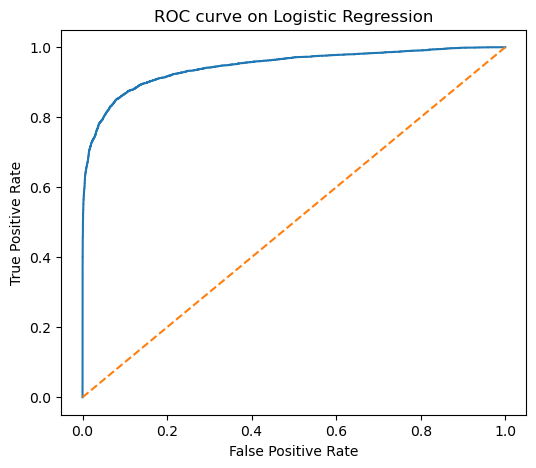

In [67]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC curve on Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()



The ROC curve stays in the top-left and above the diagonal, so the model separates defaults from non-defaults strongly; I can get high true positive rates while keeping false positives low to moderate.


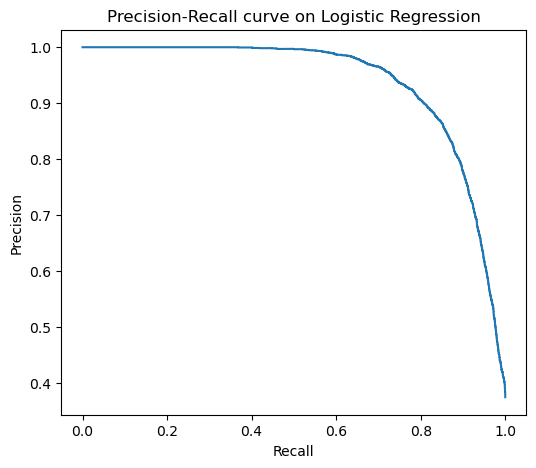

In [68]:
plt.figure(figsize=(6,5))
plt.plot(rc, pr)
plt.title("Precision-Recall curve on Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

The PR curve shows precision stays very high while recall is moderate, then drops past ~0.8?0.9 recall. With a 37% default rate, I can catch many defaulters before precision falls; pushing to extreme recall trades off precision quickly.


### How I choose a decision threshold
I choose a threshold using the precision-recall curve to balance catching defaults (recall) vs avoiding false alarms (precision). For this run, I target at least 0.80 recall; among thresholds that meet it, I pick the highest precision. This keeps more defaulters captured while limiting good loans I flag. If missing defaults is very costly, I can push recall higher; if false alarms are costly, I raise the threshold to boost precision and accept lower recall.


In [69]:
target_recall = 0.80
mask = rc[:-1] >= target_recall 
if mask.any():
    precisions_meeting_recall = pr[:-1][mask]
    idx_local = precisions_meeting_recall.argmax()
    candidate_thresholds = pr_thr[mask]
    best_threshold = candidate_thresholds[idx_local]
    print(f"Chosen threshold (recall >= {target_recall:.2f} with best precision): {best_threshold:.3f}")
    y_pred_opt = (y_proba >= best_threshold).astype(int)
    prec_opt = precision_score(y_test, y_pred_opt)
    rec_opt = recall_score(y_test, y_pred_opt)
    print(f"Precision={prec_opt:.3f}, Recall={rec_opt:.3f} at this threshold")


Chosen threshold (recall >= 0.80 with best precision): 0.665
Precision=0.906, Recall=0.800 at this threshold


### Model interpretation with Logistic Regression coefficients

Because I scaled inputs, coefficient magnitude is now more comparable. So I'll show the top positive/negative coefficients which are basically the features most associated with default probability.


In [70]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [71]:
import pandas as pd

prep = logreg_pipeline.named_steps["prep"]
feature_names = prep.get_feature_names_out()
coefs = logreg_pipeline.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
top_pos = coef_df.sort_values("coef", ascending=False).head(10)
top_neg = coef_df.sort_values("coef").head(10)

print("Top positive (higher - higher default probability):")
display(top_pos)



Top positive (higher - higher default probability):


,feature,coef
12,time2,2.691634
11,time,2.248532
163,no.previous.loan.00,0.824933
59,duration.60,0.796424
57,duration.36,0.796392
171,previous.loan.l,0.684551
6,Interest,0.680713
51,log.amount,0.461397
58,duration.48,0.341412
104,Other,0.270100


Variables like time2 and time suggest that later time snapshots are linked to a higher chance of default. Having no previous loans or a bad previous loan also increases risk. Longer loan terms (36, 48, 60 months) and higher interest rates or loan amounts are associated with more defaults. So basically bigger loans, longer repayment periods, higher interest and little or poor credit history usually mean higher risk.

In [72]:
print("Top negative (higher - lower default probability):")
display(top_neg)

Top negative (higher - lower default probability):


,feature,coef
13,time3,-7.694327
0,NPRP,-3.206337
7,MonthlyPayment,-0.473906
161,FreeCash.d,-0.408521
10,AmountOfPreviousLoansBeforeLoan,-0.271294
73,educ.5,-0.217793
132,inc.princ.empl.no,-0.217009
149,no.liab.02,-0.174904
148,no.liab.01,-0.171267
150,no.liab.03,-0.147823


The variable time3 shows the opposite effect, meaning that in this time snapshot, higher values are linked to fewer defaults, likely due to how time is encoded. Higher FreeCash.d and MonthlyPayment reduce default risk which may suggest that borrowers with more available cash or manageable payments are less likely to default. A higher number of previous loans is also linked to lower risk, showing more experienced borrowers. Some no-liability indicators and education level 5 show a small protective effect as well.

It's important to remember that these coefficients show more like associations, not direct cause or influence. Because the features are scaled, the values are comparable but results can still be affected by for example class weighting.

------

## 6. Reflection 


If I had more time and resources I would run proper cross-validation and tune the model. For example i would use the C parameter in logistic regression and tree depth/number of trees in the random forest if i used both classification methods. I’d also calibrate the predicted probabilities (maybe using Platt scaling or different regression) so that choosing a decision threshold is more reliable. I would try a few simple feature changes, like taking logs of very skewed variables like loan amount or creating ratios such as payment relative to income. I’d also  try to carefully check for data leakage, making sure that no variables from after the outcome (like return) are included.

For the extra data that could help me, i tink Credit information like credit scores, verified income and expense data and like unemployment or interest rates linked to the time variables would likely improve the model. More detailed information about job stability or industry could also add useful insights apart from what is available for me now.

How I interpret the current performance?  Since the default rate is around 37%, the PR-AUC needs to be clearly above 0.37 to be useful, which seems to be the case here. The ROC and precision–recall curves look strong. With a 0.5 threshold, there is a clear trade-off between precision and recall. If missing defaults is expensive, I would lower the threshold to catch more defaulters, even if that means more false positives. If false alarms are more costly, I would increase the threshold to avoid rejecting too many good loans.

And lastly, about the features in my data.
As I mentioned previusly, from the logistic regression, longer loan terms, higher interest rates and a lack of good previous loans increase default risk. On the other hand, NPRP/return, more free cash, and a more established borrowing history reduce risk. I know these coefficients show correlations, not direct effects, but they align well with intuition and what I observed in the EDA plots. With a PR-AUC above the 0.37 default rate and strong ROC/PR curves. Overall I’m satisfied for now because i managed to do it in 3 hours, but I’d revisit thresholds with calibration before deployment. 

------